<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from  pathlib import Path
from timeit import default_timer as timer
from tqdm import tqdm ## progress bar

100%|██████████| 26.4M/26.4M [00:00<00:00, 108MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.94MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.7MB/s]


Sample size of Train data: 60000, image: torch.Size([1, 28, 28]), label: 9
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Device: cpu


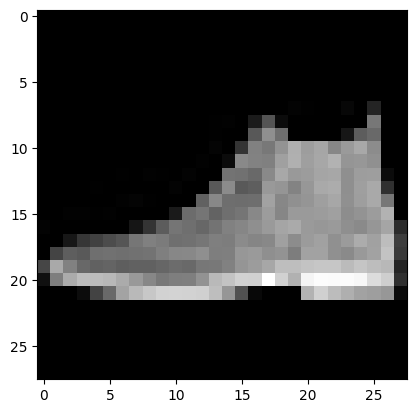

In [2]:
generator1 = torch.Generator().manual_seed(42)
# 1) Datasets
train_data = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

image, label = next(iter(test_data))
print(f"Sample size of Train data: {len(train_data)}, image: {image.size()}, label: {label}")
plt.imshow(image.squeeze(), cmap="gray")
class_name = train_data.classes
print(f"Class names: {class_name}")

# 2) Split data
split_ratio = 0.8
train_size = int(split_ratio * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size], generator=generator1)

# 3) Set device and loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin = (device.type == 'cuda')
print(f'Device: {device}')

Batch_size = 64

train_loader = DataLoader(train_data, batch_size = Batch_size, shuffle = True, pin_memory = pin)
test_loader = DataLoader(test_data, batch_size = Batch_size, shuffle = False, pin_memory = pin)

In [3]:
## Define a timer
def train_time(start, end, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

In [4]:
class ConvelutionalNN(nn.Module):

    def __init__(self, in_ch, hidden_ch, out_ch):

        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, hidden_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
            )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_ch * 7 * 7, out_ch)
        )

    def forward(self, x):
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [5]:
model = ConvelutionalNN(1, 16, 10)
# Get a batch of data from the train loader
image, label = next(iter(train_data))
image = image.unsqueeze(0)
model(image)

tensor([[ 0.0519,  0.0195,  0.0226, -0.0091, -0.0021, -0.0344,  0.0180, -0.0057,
         -0.0208,  0.0322]], grad_fn=<AddmmBackward0>)

In [6]:
model = ConvelutionalNN(1, 12, 10).to(device)

loss_fcn = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4)
optimizer = optim.Adam(model.parameters(), weight_decay = 1e-5)

epochs = 10

train_error = []
test_error = []
train_accuracy = []
test_accuracy = []
start = timer()

for epoch in tqdm(range(1, epochs + 1)):

    model.train()
    train_correct = 0
    train_loss = 0

    for X_batch, y_batch in train_loader:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_fcn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        predicted = y_pred.argmax(dim = 1)
        train_correct += (predicted == y_batch).sum().item()

    train_loss = train_loss / len(train_data)
    train_acc = train_correct / len(train_data) * 100

    model.eval()
    with torch.inference_mode():

        test_loss = 0
        test_correct = 0

        for X_batch, y_batch in test_loader:

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)

            loss = loss_fcn(y_pred, y_batch)
            test_loss += loss.item() * len(X_batch)

            predicted = y_pred.argmax(dim = 1)
            test_correct += (predicted == y_batch).sum().item()

        test_loss = test_loss / len(test_data)
        test_acc = test_correct / len(test_data) * 100

        train_error.append(train_loss)
        test_error.append(test_loss)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        if epoch % 1 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Test loss: {test_loss: .4f} | Test accuracy: {test_acc:.2f}%")


end = timer()
train_time(start, end, device)

 10%|█         | 1/10 [00:16<02:30, 16.70s/it]

Epoch: 1 | Train loss:  0.6370 | Test loss:  0.4657 | Test accuracy: 82.86%


 20%|██        | 2/10 [00:33<02:13, 16.69s/it]

Epoch: 2 | Train loss:  0.3821 | Test loss:  0.3728 | Test accuracy: 86.57%


 30%|███       | 3/10 [00:50<01:57, 16.75s/it]

Epoch: 3 | Train loss:  0.3384 | Test loss:  0.3431 | Test accuracy: 87.86%


 40%|████      | 4/10 [01:06<01:40, 16.70s/it]

Epoch: 4 | Train loss:  0.3160 | Test loss:  0.3293 | Test accuracy: 88.20%


 50%|█████     | 5/10 [01:23<01:24, 16.82s/it]

Epoch: 5 | Train loss:  0.2969 | Test loss:  0.3167 | Test accuracy: 88.75%


 60%|██████    | 6/10 [01:40<01:07, 16.91s/it]

Epoch: 6 | Train loss:  0.2834 | Test loss:  0.3060 | Test accuracy: 89.04%


 70%|███████   | 7/10 [01:57<00:50, 16.82s/it]

Epoch: 7 | Train loss:  0.2726 | Test loss:  0.3075 | Test accuracy: 88.74%


 80%|████████  | 8/10 [02:15<00:34, 17.09s/it]

Epoch: 8 | Train loss:  0.2633 | Test loss:  0.3007 | Test accuracy: 89.41%


 90%|█████████ | 9/10 [02:32<00:17, 17.05s/it]

Epoch: 9 | Train loss:  0.2531 | Test loss:  0.2889 | Test accuracy: 89.78%


100%|██████████| 10/10 [02:49<00:00, 16.92s/it]

Epoch: 10 | Train loss:  0.2461 | Test loss:  0.2899 | Test accuracy: 89.58%
Train time on cpu: 169.205 seconds


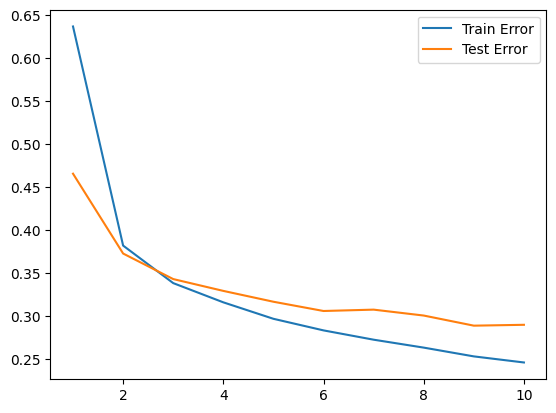

In [7]:
## plot error
x = np.arange(1, epochs +1)
plt.plot(x, train_error, label = "Train Error")
plt.plot(x, test_error, label = "Test Error")
plt.legend()

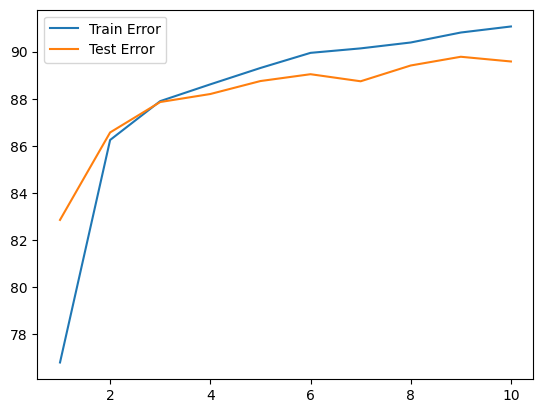

In [8]:
## plot accuracy
plt.plot(x, train_accuracy, label = "Train Error")
plt.plot(x, test_accuracy, label = "Test Error")
plt.legend()